<a href="https://colab.research.google.com/github/ArpitKadam/Attention-Is-All-You-Code/blob/main/LLM-from-Scratch/CHP_09_Coding_GPT_to_Predict_the_Next_Token.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CODING THE GPT-2 MODEL TO PREDICT THE NEXT TOKEN**

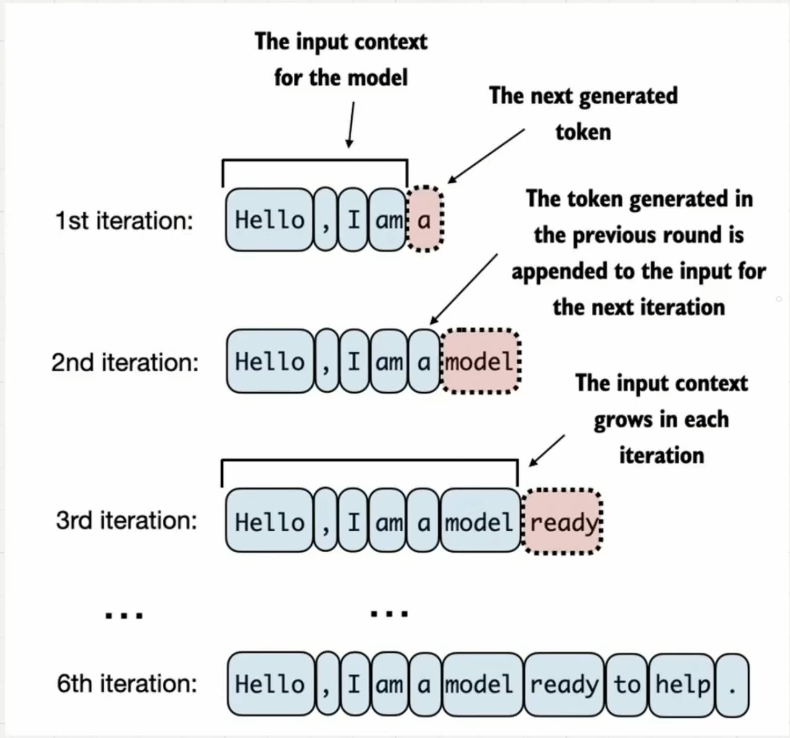

In [1]:
import torch
import torch.nn as nn

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias":False
}

class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x-mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
    ))

class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
        GELU(),
        nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
    )

  def forward(self, x):
    return self.layers(x)

class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, drop_rate, num_heads, qkv_bias):
    super().__init__()
    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads

    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(drop_rate)
    self.register_buffer("simple_mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, x):
    batch, num_tokens, d_in = x.shape

    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)
    values = values.view(batch, num_tokens, self.num_heads, self.head_dim)

    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2)

    attn_scores = torch.matmul(queries, keys.transpose(2, 3))

    attn_scores.masked_fill_(
        self.simple_mask.bool()[:num_tokens, :num_tokens],
        -torch.inf
    )

    attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)

    attn_weights = self.dropout(attn_weights)

    context_vec = torch.matmul(attn_weights, values)

    context_vec = context_vec.transpose(1, 2)

    context_vec = context_vec.contiguous().view(batch, num_tokens, self.d_out)

    context_vec = self.out_proj(context_vec)

    return context_vec

class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.attn = MultiHeadAttention(
        d_in = cfg['emb_dim'],
        d_out = cfg['emb_dim'],
        context_length = cfg['context_length'],
        num_heads = cfg['n_heads'],
        qkv_bias = cfg['qkv_bias'],
        drop_rate = cfg['drop_rate']
      )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg['emb_dim'])
    self.norm2 = LayerNorm(cfg['emb_dim'])
    self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

  def forward(self, x):
    ## Connection for attention block
    shortcut = x
    x = self.norm1(x)
    x = self.attn(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    ## Conection for feed forward block
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x

class GPT_MODEL(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.token_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
    self.drop_out = nn.Dropout(cfg['drop_rate'])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
    )

    self.final_norm = LayerNorm(cfg['emb_dim'])
    self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

  def forward(self, x):
    batch_size, seq_length = x.shape

    token_embeddings = self.token_emb(x)
    pos_embeddings = self.pos_emb(torch.arange(seq_length, device=x.device))

    x = token_embeddings + pos_embeddings
    x = self.drop_out(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)

    return logits

In [2]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):

    ## Crop current context if it exceeds the supported context size
    ## E.g if LLM supports only 5 tokens, and the context size is 10,
    ## then only last 5 tokens are used as context
    idx_crop = idx[:, -context_size:]

    ## Get the predictions
    with torch.no_grad():
      logits = model(idx_crop)

    ## Focus only on the last time steps
    ## (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
    logits = logits[:, -1, :]

    ## Apply softmax to get probabilities
    probas = torch.softmax(logits, dim=-1)

    ## Get the id of vocab entry with highest probability
    idx_next = torch.argmax(probas, dim=-1, keepdim=True)

    idx = torch.cat((idx, idx_next), dim=1)

  return idx

In [4]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
encoded_tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0)
print("Encoded Tensor Length:", encoded_tensor.shape)
print("Encoded Tensor:", encoded_tensor)

Encoded Tensor Length: torch.Size([1, 4])
Encoded Tensor: tensor([[15496,    11,   314,   716]])


In [5]:
model = GPT_MODEL(GPT_CONFIG_124M)
print(model)

GPT_MODEL(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_out): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_fe

In [7]:
model.eval()
output = generate_text_simple(model, encoded_tensor, 6, GPT_CONFIG_124M['context_length'])

In [8]:
print("Output Shape:", output.shape)
print("Output:", output)

Output Shape: torch.Size([1, 10])
Output: tensor([[15496,    11,   314,   716, 13690,   691, 31056, 23223, 43440,  5380]])


In [12]:
decoded_text = tokenizer.decode(output.squeeze(0).tolist())
print("Decoded Text:", decoded_text)

Decoded Text: Hello, I am Cart onlySon Rid resultant seek
